**Contexte** : mêler mes passions pour les données et pour la course à pied au sein d’un même projet

**Objectif** : évaluer mes progrès en course et montrer mes compétences en data analyse

**Données** : les activités enregistrées par ma montre connectée


### a. Import des bibliothèques

In [25]:
!pip install garminconnect

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

import os
from garminconnect import Garmin, GarminConnectConnectionError, GarminConnectTooManyRequestsError
from getpass import getpass

### b. Chargement des données

In [27]:
email = getpass('GARMIN_EMAIL')
password = getpass('GARMIN_PASSWORD')

GARMIN_EMAIL··········
GARMIN_PASSWORD··········


In [28]:
try:
    client = Garmin(email, password)
    client.login()
    print("Connexion réussie!")
except GarminConnectConnectionError as err:
    print(f"Erreur de connexion : {err}")
except GarminConnectTooManyRequestsError as err:
    print(f"Trop de requêtes envoyées : {err}")
except Exception as err:
    print(f"Une erreur est survenue : {err}")

Connexion réussie!


In [29]:
"""
Récupère toutes les activités de l'utilisateur par lots.

Args:
    client: Instance du client Garmin Connect.
    batch_size: Nombre d'activités à récupérer par requête (défaut : 100).

Returns:
    List[dict]: Liste de toutes les activités.
"""
def fetch_all_activities(client, batch_size=100):
    activities = []
    start = 0

    while True:
        print(f"Récupération des activités {start} à {start + batch_size}...")
        batch = client.get_activities(start, batch_size)
        if not batch:  # Si le lot est vide, on a tout récupéré
            break
        activities.extend(batch)
        start += batch_size

    return activities

In [30]:
try:
    activities = fetch_all_activities(client)
    print(f"Nombre total d'activités récupérées : {len(activities)}")
except Exception as e:
    print(f"Erreur lors de la récupération des activités : {e}")

data = pd.DataFrame(activities)

Récupération des activités 0 à 100...
Récupération des activités 100 à 200...
Récupération des activités 200 à 300...
Récupération des activités 300 à 400...
Récupération des activités 400 à 500...
Récupération des activités 500 à 600...
Récupération des activités 600 à 700...
Nombre total d'activités récupérées : 584


### c. Transformation des données

In [31]:
data = data[['activityId', 'activityType', 'startTimeLocal', 'distance', 'duration', 'elevationGain', 'elevationLoss', 'averageSpeed', 'averageRunningCadenceInStepsPerMinute', 'avgStrideLength', 'averageHR']]

In [32]:
data.head()

,activityId,activityType,startTimeLocal,distance,duration,elevationGain,elevationLoss,averageSpeed,averageRunningCadenceInStepsPerMinute,avgStrideLength,averageHR
0,17628215492,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...",2024-11-26 16:40:28,12750.769531,4340.453125,71.811665,74.599136,2.938,138.718750,124.413607,NaN
1,17621137217,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...",2024-11-25 18:50:26,11930.349609,3621.277100,122.493786,126.978214,3.295,161.281250,122.562830,NaN
2,17609985096,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...",2024-11-24 09:56:59,14093.139648,4401.375977,94.139187,86.805866,3.202,160.984375,119.340214,NaN
3,17602086493,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...",2024-11-23 08:26:51,15050.049805,4628.609863,86.921818,86.053032,3.252,157.953125,122.403912,NaN
4,17595809645,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...",2024-11-22 10:52:35,5954.410156,2098.336914,41.140656,42.532295,2.838,157.000000,108.446396,NaN


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584 entries, 0 to 583
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   activityId                             584 non-null    int64  
 1   activityType                           584 non-null    object 
 2   startTimeLocal                         584 non-null    object 
 3   distance                               584 non-null    float64
 4   duration                               584 non-null    float64
 5   elevationGain                          564 non-null    float64
 6   elevationLoss                          563 non-null    float64
 7   averageSpeed                           584 non-null    float64
 8   averageRunningCadenceInStepsPerMinute  569 non-null    float64
 9   avgStrideLength                        569 non-null    float64
 10  averageHR                              249 non-null    float64
dtypes: flo

In [34]:
data['activityTypeKey'] = data['activityType'].apply(lambda x: x['typeKey'])

data['startTimeLocal'] = pd.to_datetime(data['startTimeLocal'])

data['distance (km)'] = data['distance'].apply(lambda x: x / 1000)

data['duration (h)'] = data['duration'].apply(lambda x: x / 3600)

data['elevationGain (m)'] = data['elevationGain'].apply(lambda x: x / 100)

data['elevationLoss (m)'] = data['elevationLoss'].apply(lambda x: x / 100)

data['averageSpeed (km/h)'] = data['averageSpeed'].apply(lambda x: x / 1000)

### d. Analyse, nettoyage et visualisation des données

#### **Combien d'activités par type d'activité ?**

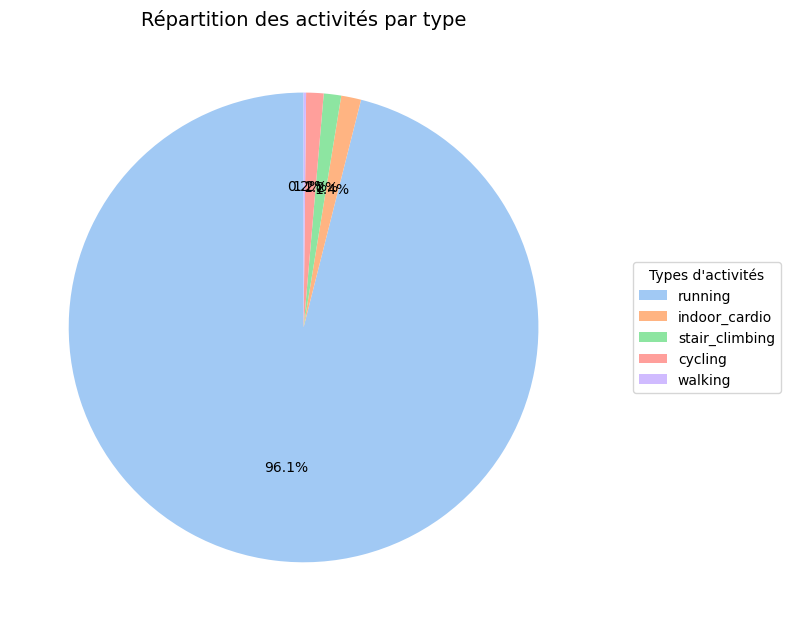

In [35]:
activity_counts = data['activityTypeKey'].value_counts()

palette = sns.color_palette("pastel", len(activity_counts))

plt.figure(figsize=(8, 8))
activity_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=palette, labels=None)
plt.title('Répartition des activités par type', fontsize=14)
plt.legend(activity_counts.index, title='Types d\'activités', bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.ylabel('')
plt.tight_layout()
plt.show()

Pour la suite de l'analyse, filtrons uniquement sur mes activités de course.

In [36]:
data = data[data['activityTypeKey'] == 'running']

#### **Combien d'activités par tranche de distance ?**

[Text(0.5, 1.0, 'Distance Distribution')]

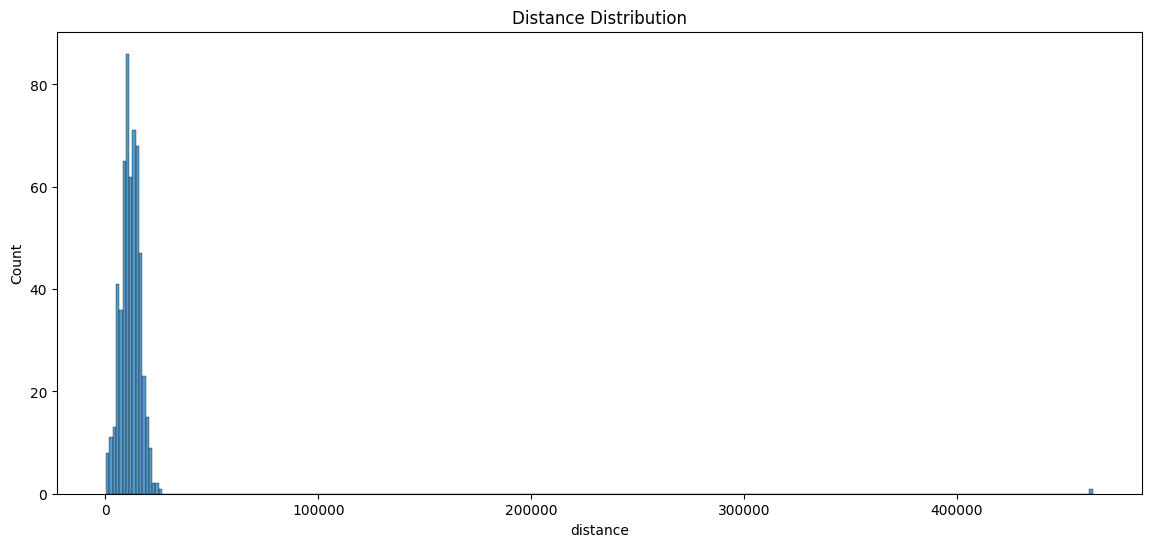

In [37]:
plt.figure(figsize=(14,6))
sns.histplot(data=data, x='distance').set(title='Distance Distribution')

Nous détectons un outlier. Filtrons sur les activités dont la distance est supérieure à 50km pour en savoir plus.

In [38]:
data[data['distance (km)'] > 50]

,activityId,activityType,startTimeLocal,distance,duration,elevationGain,elevationLoss,averageSpeed,averageRunningCadenceInStepsPerMinute,avgStrideLength,averageHR,activityTypeKey,distance (km),duration (h),elevationGain (m),elevationLoss (m),averageSpeed (km/h)
546,6647433503,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...",2021-04-21 18:10:24,463911.53125,3367.910889,101.183067,104.531517,6.673,154.921875,116.697734,160.0,running,463.911531,0.935531,1.011831,1.045315,0.006673


Une activité affiche une distance de... 463km ! Effectuée en moins d'1 heure !! Cette activité est effectivement aberrante. Supprimons-la du dataset.

In [39]:
data = data[data['activityId'] != 6647433503]

Voici la nouvelle distribution !

[Text(0.5, 1.0, 'Distance Distribution')]

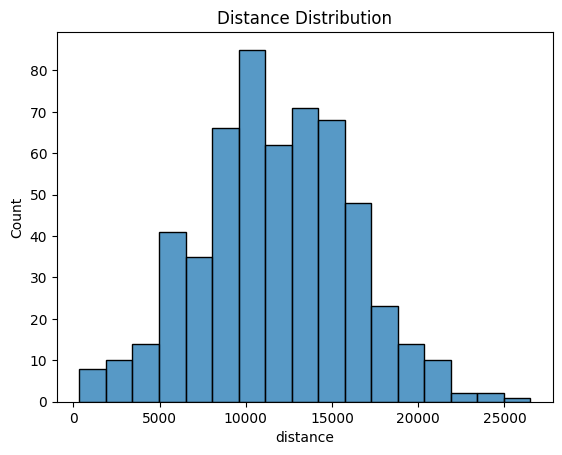

In [40]:
sns.histplot(data=data, x='distance').set(title='Distance Distribution')

#### **Comment a évolué la distance parcourue au cours de la saison 2022 ?**

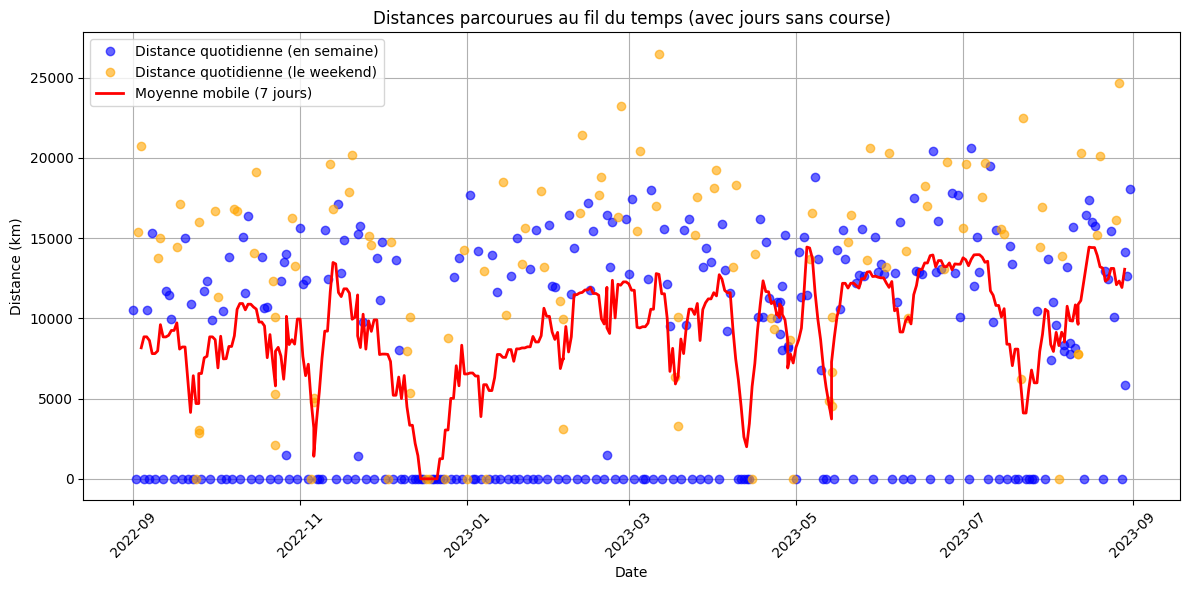

In [41]:
START_DATE = datetime.strptime('2022-09-01', '%Y-%m-%d')
END_DATE = datetime.strptime('2023-08-31', '%Y-%m-%d')

d = data[(data['startTimeLocal'] >= START_DATE) & (data['startTimeLocal'] < END_DATE+timedelta(days=1))]
d = d.groupby(['startTimeLocal'])['distance'].sum().reset_index()
d['startTimeLocal'] = d['startTimeLocal'].dt.normalize()

all_dates = pd.date_range(start=START_DATE, end=END_DATE)
d_full = pd.DataFrame({'startTimeLocal': all_dates})
d_full = d_full.merge(d, on='startTimeLocal', how='left')
d_full['distance'] = d_full['distance'].fillna(0)

d_full['distance_rolling_avg'] = d_full['distance'].rolling(window=7, center=True).mean()

d_full['weekday'] = d_full['startTimeLocal'].dt.weekday

plt.figure(figsize=(12, 6))

plt.plot(d_full[d_full['weekday'] < 5]['startTimeLocal'],
         d_full[d_full['weekday'] < 5]['distance'],
         color='blue', marker='o', linestyle='',
         label="Distance quotidienne (en semaine)", alpha=0.6)  # Lundi à Vendredi en bleu
plt.plot(d_full[d_full['weekday'] >= 5]['startTimeLocal'],
         d_full[d_full['weekday'] >= 5]['distance'],
         color='orange', marker='o', linestyle='',
         label="Distance quotidienne (le weekend)", alpha=0.6)  # Samedi et Dimanche en orange
plt.plot(d_full['startTimeLocal'], d_full['distance_rolling_avg'], color='red',
         linewidth=2, label="Moyenne mobile (7 jours)")

plt.xlabel("Date")
plt.ylabel("Distance (km)")
plt.title("Distances parcourues au fil du temps (avec jours sans course)")

plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

**Observations** :
- La période sans course fin 2022 correspond à une blessure, celle d'avril 2023 à une maladie.
-  Il semble que les activités du weekend soient surreprésentées parmi les longues distances. Confirmons cela en ajustant la distribution des distances.

[Text(0.5, 1.0, 'Distance Distribution Per Day Type')]

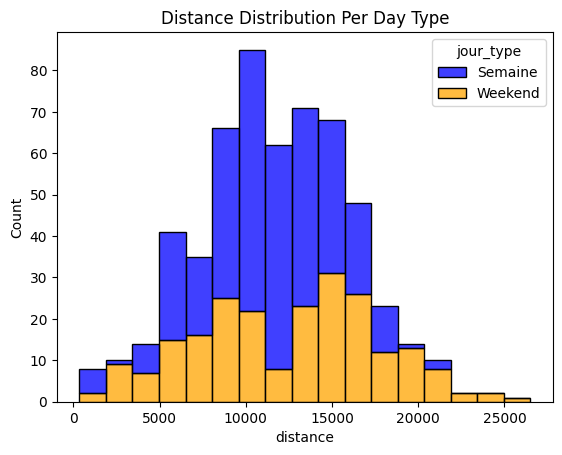

In [42]:
data['jour_type'] = data['startTimeLocal'].dt.weekday.apply(lambda x: 'Weekend' if x >= 5 else 'Semaine')

sns.histplot(data=data, x='distance', hue='jour_type',
             hue_order=['Semaine', 'Weekend'],
             palette={'Weekend': 'orange', 'Semaine': 'blue'},
             multiple='stack').set(title='Distance Distribution Per Day Type')

#### **Comment a évolué ma cadence de course entre 2022 et 2023 ?**

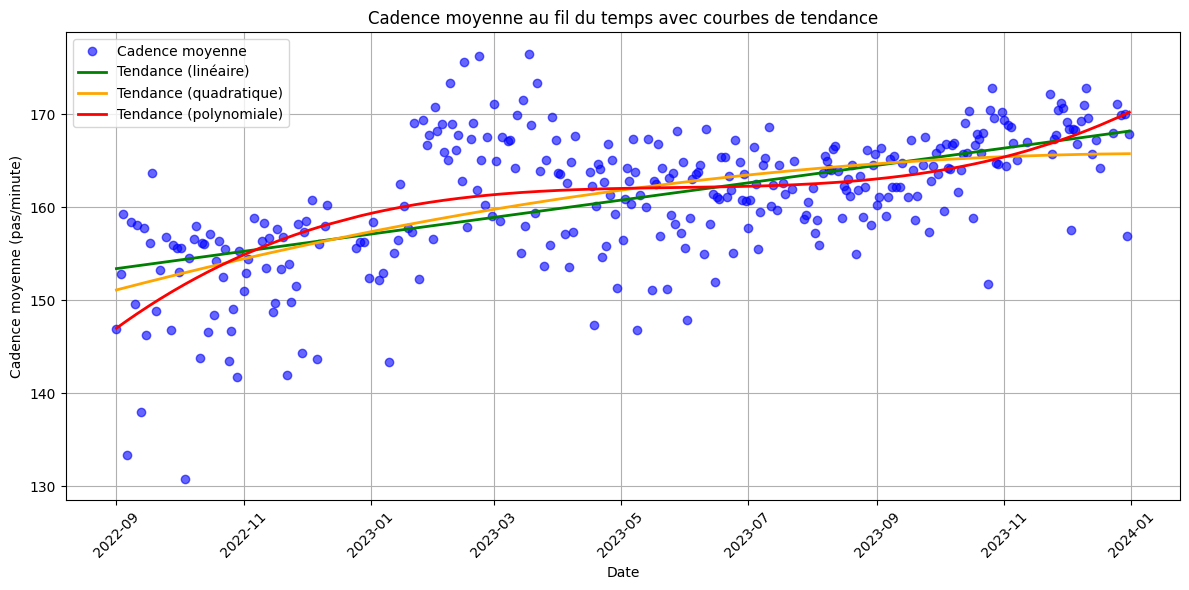

In [43]:
START_DATE = datetime.strptime('2022-09-01', '%Y-%m-%d')
END_DATE = datetime.strptime('2023-12-31', '%Y-%m-%d')

d = data[(data['startTimeLocal'] >= START_DATE) & (data['startTimeLocal'] < END_DATE+timedelta(days=1))]
d.loc[:, 'startTimeLocal'] = d['startTimeLocal'].dt.normalize()
d = d.groupby(['startTimeLocal'])['averageRunningCadenceInStepsPerMinute'].mean().reset_index()

# Convertir les dates en valeurs numériques pour la régression
d['date_numeric'] = (d['startTimeLocal'] - d['startTimeLocal'].min()).dt.days

# Calculer la courbe de tendance (polynomiale de degré 3 par exemple)
d1_coefficients = np.polyfit(d['date_numeric'], d['averageRunningCadenceInStepsPerMinute'], deg=1)
d1_trend = np.polyval(d1_coefficients, d['date_numeric'])
d2_coefficients = np.polyfit(d['date_numeric'], d['averageRunningCadenceInStepsPerMinute'], deg=2)
d2_trend = np.polyval(d2_coefficients, d['date_numeric'])
d3_coefficients = np.polyfit(d['date_numeric'], d['averageRunningCadenceInStepsPerMinute'], deg=3)
d3_trend = np.polyval(d3_coefficients, d['date_numeric'])

plt.figure(figsize=(12, 6))

plt.plot(d['startTimeLocal'],
         d['averageRunningCadenceInStepsPerMinute'],
         color='blue', marker='o', linestyle='',
         label="Cadence moyenne", alpha=0.6)

plt.plot(d['startTimeLocal'], d1_trend, color='green', linewidth=2, label="Tendance (linéaire)")
plt.plot(d['startTimeLocal'], d2_trend, color='orange', linewidth=2, label="Tendance (quadratique)")
plt.plot(d['startTimeLocal'], d3_trend, color='red', linewidth=2, label="Tendance (polynomiale)")

plt.xlabel("Date")
plt.ylabel("Cadence moyenne (pas/minute)")
plt.title("Cadence moyenne au fil du temps avec courbes de tendance")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

**Observations** :
* On constate une tendance à la hausse de la cadence moyenne des activités ;
* Cette évolution résulte d'un travail conscient, consécutif à la blessure subie fin 2022 ;
* La courbe de tendance polynomiale permet même de voir que cette évolution s'est faite en 3 temps : une exagération de la cadence suivie d'une baisse avant une augmentation plus pérenne et mieux intégrée par le corps.

**Comment a évolué la longueur de ma foulée entre 2022 et 2023 ?**

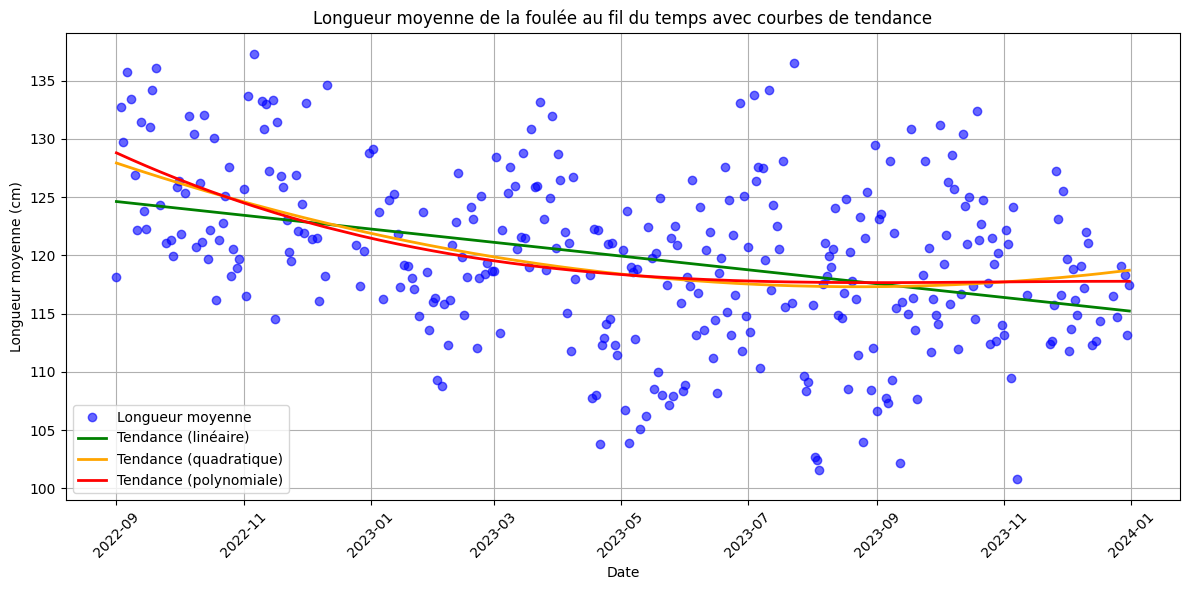

In [44]:
START_DATE = datetime.strptime('2022-09-01', '%Y-%m-%d')
END_DATE = datetime.strptime('2023-12-31', '%Y-%m-%d')

d = data[(data['startTimeLocal'] >= START_DATE) & (data['startTimeLocal'] < END_DATE+timedelta(days=1))]
d.loc[:, 'startTimeLocal'] = d['startTimeLocal'].dt.normalize()
d = d.groupby(['startTimeLocal'])['avgStrideLength'].mean().reset_index()


# Convertir les dates en valeurs numériques pour la régression
d['date_numeric'] = (d['startTimeLocal'] - d['startTimeLocal'].min()).dt.days

# Calculer la courbe de tendance (polynomiale de degré 3 par exemple)
d1_coefficients = np.polyfit(d['date_numeric'], d['avgStrideLength'], deg=1)
d1_trend = np.polyval(d1_coefficients, d['date_numeric'])
d2_coefficients = np.polyfit(d['date_numeric'], d['avgStrideLength'], deg=2)
d2_trend = np.polyval(d2_coefficients, d['date_numeric'])
d3_coefficients = np.polyfit(d['date_numeric'], d['avgStrideLength'], deg=3)
d3_trend = np.polyval(d3_coefficients, d['date_numeric'])

# Visualisation
plt.figure(figsize=(12, 6))

# Points des données originales
plt.plot(d['startTimeLocal'],
         d['avgStrideLength'],
         color='blue', marker='o', linestyle='',
         label="Longueur moyenne", alpha=0.6)

# Courbe de tendance
plt.plot(d['startTimeLocal'], d1_trend, color='green', linewidth=2, label="Tendance (linéaire)")
plt.plot(d['startTimeLocal'], d2_trend, color='orange', linewidth=2, label="Tendance (quadratique)")
plt.plot(d['startTimeLocal'], d3_trend, color='red', linewidth=2, label="Tendance (polynomiale)")

plt.xlabel("Date")
plt.ylabel("Longueur moyenne (cm)")
plt.title("Longueur moyenne de la foulée au fil du temps avec courbes de tendance")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

**Observations** :
* La tendance linéaire montre une baisse de la longueur moyenne de la foulée ;
* Les tendances quadratiques et polynomiales montrent toutefois qu'il y a d'abord une forte baisse avant une stabilisation.